In [1]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/35Msun_GWTC3/m1m2_cut`


h_plot (generic function with 1 method)

# Load GWTC-3 Parameter Estimation and Selection Samples

In [2]:
## Samples and Selection

## Set up paths
struct Paths
    gwtc_2_dir::String
    gwtc_3_dir::String
    evt_table_file::String
    o1o2o3_sensitivity_file::String
end

paths = Paths(
    "/mnt/home/ccalvk/ceph/GWTC-2.1", 
    "/mnt/home/ccalvk/ceph/GWTC-3", 
    "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json",
    "/mnt/home/ccalvk/ceph/sensitivity-estimates/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5"
)

Paths("/mnt/home/ccalvk/ceph/GWTC-2.1", "/mnt/home/ccalvk/ceph/GWTC-3", "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json", "/mnt/home/ccalvk/ceph/sensitivity-estimates/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5")

In [3]:
## Load PE
all_pe = load_pe(; gwtc_2_dir=paths.gwtc_2_dir, gwtc_3_dir=paths.gwtc_3_dir)
evt_table = load_event_table(paths.evt_table_file)
all_pe = join_pe_evt_tables(all_pe, evt_table)

┌ Info: Could not read IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5
└ @ BumpCosmologyGWTC3 /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/src/load.jl:26


5294107×48 DataFrame
     Row │ spin_2y      dec         chirp_mass  redshift   theta_jn  ra        ⋯
         │ Float64      Float64     Float64     Float64    Float64   Float64   ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │  0.0157482   -1.2029        30.9684  0.0968552  2.77079   1.28323   ⋯
       2 │  0.306186    -1.17447       31.6976  0.0858721  2.58701   1.12687
       3 │ -0.281979    -1.20404       29.1559  0.0984072  2.65664   2.28386
       4 │ -0.0257892   -1.28148       29.4337  0.0788087  2.46328   1.66579
       5 │ -0.615255    -1.22545       28.3426  0.093687   2.78603   2.18355   ⋯
       6 │  0.0101604   -1.2815        30.2896  0.105684   2.71688   1.89592
       7 │ -0.0143139   -1.22618       30.8565  0.120825   2.83255   2.33255
       8 │ -0.00522301  -1.25144       29.8868  0.118836   3.04766   2.17208
    ⋮    │      ⋮           ⋮           ⋮           ⋮         ⋮         ⋮      ⋱
 5294101 │  0.0211677   -1.39546       15.684   2.12274    1.25283   5.43618   ⋯
 5294102 │ -0.00390516   0.64649      115.447   2.83352    0.86683   2.58729
 5294103 │ -0.421287     0.894574      36.9237  2.3867     0.71974   4.64336
 5294104 │  0.147633     0.0648217     75.7566  1.93645    1.68646   2.05282
 5294105 │ -0.0930473   -0.472434      77.4303  1.58402    2.35974   4.3899    ⋯
 5294106 │ -0.0794067   -0.158908     118.144   2.6258     1.7231    0.396216
 5294107 │ -0.377114     0.959945      63.2025  2.61006    1.57776   3.17783
                                             42 columns and 5294092 rows omitted

Select PE Samples such that:
$$
\mathrm{PE~Pos}(m_1>20, m_2=[3,50])>0.5
$$

In [4]:
groups = groupby(far_cut(mass_cut(all_pe, thresh=0.5)), :gwname)
gw_names = [group.gwname[1] for group in groups]

open("../data/analyzed_gw_event_names.txt", "w") do io
    for name in gw_names
        println(io, name)
    end
end

println(gw_names)
println(length(gw_names))

SubString{String}["GW150914_095045", "GW151012_095443", "GW170104_101158", "GW170729_185629", "GW170809_082821", "GW170814_103043", "GW170818_022509", "GW170823_131358", "GW190408_181802", "GW190412_053044", "GW190413_052954", "GW190413_134308", "GW190421_213856", "GW190503_185404", "GW190512_180714", "GW190513_205428", "GW190517_055101", "GW190519_153544", "GW190521_074359", "GW190527_092055", "GW190602_175927", "GW190620_030421", "GW190630_185205", "GW190701_203306", "GW190706_222641", "GW190719_215514", "GW190727_060333", "GW190731_140936", "GW190803_022701", "GW190805_211137", "GW190828_063405", "GW190828_065509", "GW190910_112807", "GW190915_235702", "GW190925_232845", "GW190929_012149", "GW191109_010717", "GW191127_050227", "GW191215_223052", "GW191222_033537", "GW191230_180458", "GW200112_155838", "GW200128_022011", "GW200129_065458", "GW200208_130117", "GW200209_085452", "GW200216_220804", "GW200219_094415", "GW200224_222234", "GW200302_015811", "GW200311_115853"]
51


# Plot PE Samples
## $m_1-m_2$ Plane

In [5]:
function frac_mass_bounds(df, m1_min, m2_min, m2_max)
    m1s = df[!, :mass_1_source]
    m2s = df[!, :mass_2_source]
    p_in = sum((m1s .> m1_min) .&& (m2s .> m2_min) .&& (m2s .< m2_max)) / length(m1s)
    p_in
end

function m1m2_kde_plot(df;
    m1_min = 20.0,
    m2_min = 3.0,
    m2_max = 50.0,
    include_legend=false,
    p_cut=[0.9, 0.5, 0.1],
    p_cut_eventlist=0.0,
    rng=Random.default_rng(),
    far_thresh=1,
    alpha_factor=0.5,
    level=0.1,
    draw_cut_lines=false
)
    if p_cut != p_cut_eventlist
        @info("Events will be plotted with p > $(p_cut_eventlist), but reduced by alpha*=$(alpha_factor) at thresholds p < $(p_cut)")
    end

    evt_groups = DataFrames.groupby(df, :gwname)

    # Only apply chirp mass and FAR filtering — no m1/m2 filter
    evt_groups = [
        evt for evt in evt_groups
        if frac_mass_bounds(evt, m1_min, m2_min, m2_max) >= p_cut_eventlist &&
           evt[1, :far] < far_thresh
    ]

    cs = categorical_palette(length(evt_groups))

    mlow = 0.0
    mhigh = 100.0

    f = Figure(size=(800, 600))
    a = Axis(f[1, 1];
        xlabel=L"\mathrm{Primary~Mass~(in~} M_\odot)",
        ylabel=L"\mathrm{Secondary~Mass~(in~} M_\odot)",
        xlabelsize=22, ylabelsize=22, titlesize=24,
        limits=(mlow,mhigh,mlow,mhigh),
        title=L"\mathrm{PE~Pos}~(m_1>20\mathrm{M}_{\odot},~3\mathrm{M}_{\odot}<m_2<50\mathrm{M}_{\odot})>0.5",
        xminorgridvisible=true, xminorticksvisible=true,
        yminorgridvisible=true, yminorticksvisible=true
    )

    # Exclusion regions (shaded)
    if draw_cut_lines
        m1_min = 20.0
        m2_min = 3.0
        m2_max = 50.0

        # Left of m1=20
        poly!(a, [0.0, m1_min, m1_min], [0.0, 0.0, m1_min], color=(:grey, 0.25))
        # Below m2=3
        poly!(a, [m1_min, m1_min, 100.0, 100.0], [0.0, m2_min , m2_min, 0.0], color=(:grey, 0.25))
        # Above m2=50
        poly!(a, [m2_max, 100.0, 100.0], [m2_max, 100.0, m2_max], color=(:grey, 0.25))
    end

    # m1 < m2 region
    band!(a, [mlow, mhigh], [mlow, mhigh], [mhigh, mhigh], color=(:grey, 0.25))

    @progress for (i, evt) in enumerate(evt_groups)
        alpha = 1.0
        p = frac_mass_bounds(evt, m1_min, m2_min, m2_max)
        for pc in p_cut
            if p > pc
                break
            else
                alpha *= alpha_factor
            end
        end

        c = (cs[i], alpha)
        npe = size(evt, 1)
        ndraw = min(256, npe)
        draw_inds = randperm(rng, npe)[1:ndraw]

        evt_draw = evt[draw_inds, :]

        x = evt_draw[!, :mass_1_source]
        y = evt_draw[!, :mass_2_source]
        kde_pts = vcat(x', y')
        k = KDE(kde_pts)
        p_kde_pts = [pdf(k, [kde_pts[1,i], kde_pts[2,i]]) + pdf(k, [kde_pts[2,i], kde_pts[1,i]]) for i in axes(kde_pts, 2)]

        p = quantile(p_kde_pts, level)

        dx = maximum(x) - minimum(x)
        xgrid = range(minimum(x)-0.1*dx, maximum(x)+0.1*dx, length=128)

        dy = maximum(y) - minimum(y)
        ygrid = range(minimum(y)-0.1*dy, maximum(y)+0.1*dy, length=129)

        zgrid = [(x ≥ y ? pdf(k, [x, y]) + pdf(k, [y, x]) : zero(x)) for x in xgrid, y in ygrid]

        contour!(a, xgrid, ygrid, zgrid; levels=[p], color=c)
    end

    if include_legend
        Legend(f[2,1],
            [LineElement(color=cs[i], linestyle=nothing) for i in 1:length(evt_groups)],
            [evt[1, :gwname] for evt in evt_groups],
            nbanks=3)
    end

    return f
end

m1m2_kde_plot (generic function with 1 method)

┌ Info: Events will be plotted with p > 0.0, but reduced by alpha*=0.5 at thresholds p < 0.5
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sdnNjb2RlLXJlbW90ZQ==.jl:22


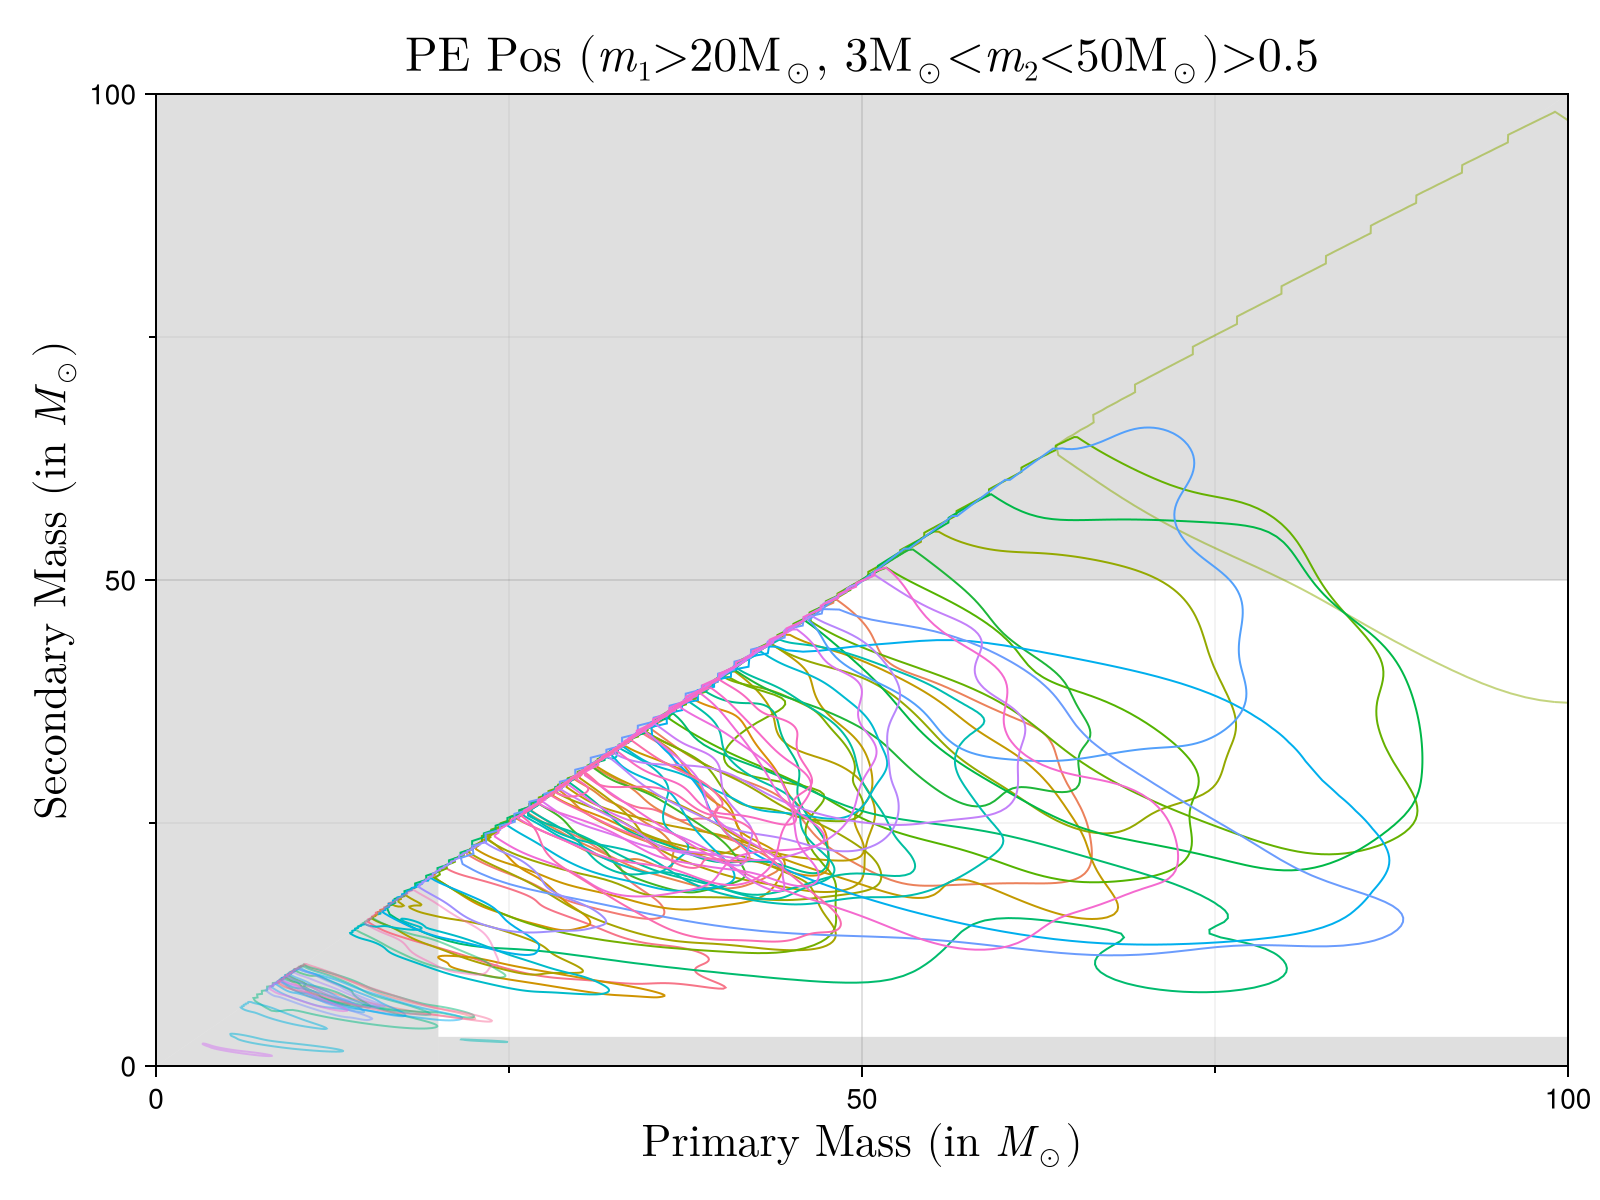

In [6]:
f = m1m2_kde_plot(all_pe; p_cut=0.5, p_cut_eventlist=0.0, draw_cut_lines=true)
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/m1_m2_kde.pdf", f, px_per_unit = 3)
f

## $q-\chi_{\mathrm{eff}}$ Plane

In [7]:
# Grouped data
pe_grouped = groups
rng = Random.Xoshiro(0xaf91589a0f32ada4)

# Create figure and axis
f = Figure(size=(800, 600))
a = Axis(f[1, 1],
    xlabel = L"\mathrm{Effective~Spin,~}\chi_\mathrm{eff}",
    ylabel = L"\mathrm{Mass~Ratio,~}q",
    xlabelsize = 25,
    ylabelsize = 25,
    titlesize=25,
    limits = ((-0.5, 1.0), (0, 1)),  # chi_eff from -1.2 to 1.2, q from 0 to 1
    title=L"q-\chi_{\mathrm{eff}}~\mathrm{PEs~for~Selected~Events}"
)

# Background: all events in grey
@progress for evt in pe_grouped
    inds = rand(rng, 1:size(evt, 1), 256)
    e = evt[inds, :]
    e = filter(:mass_ratio => q -> q ≤ 1, e)
    isempty(e) && continue
    kdecontour!(a, e.chi_eff, e.mass_ratio, color = (:grey, 0.3), levels = [0.1])
end

# Save the figure
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/q_chieff_kde.pdf", f, px_per_unit = 3)

f

## z Space

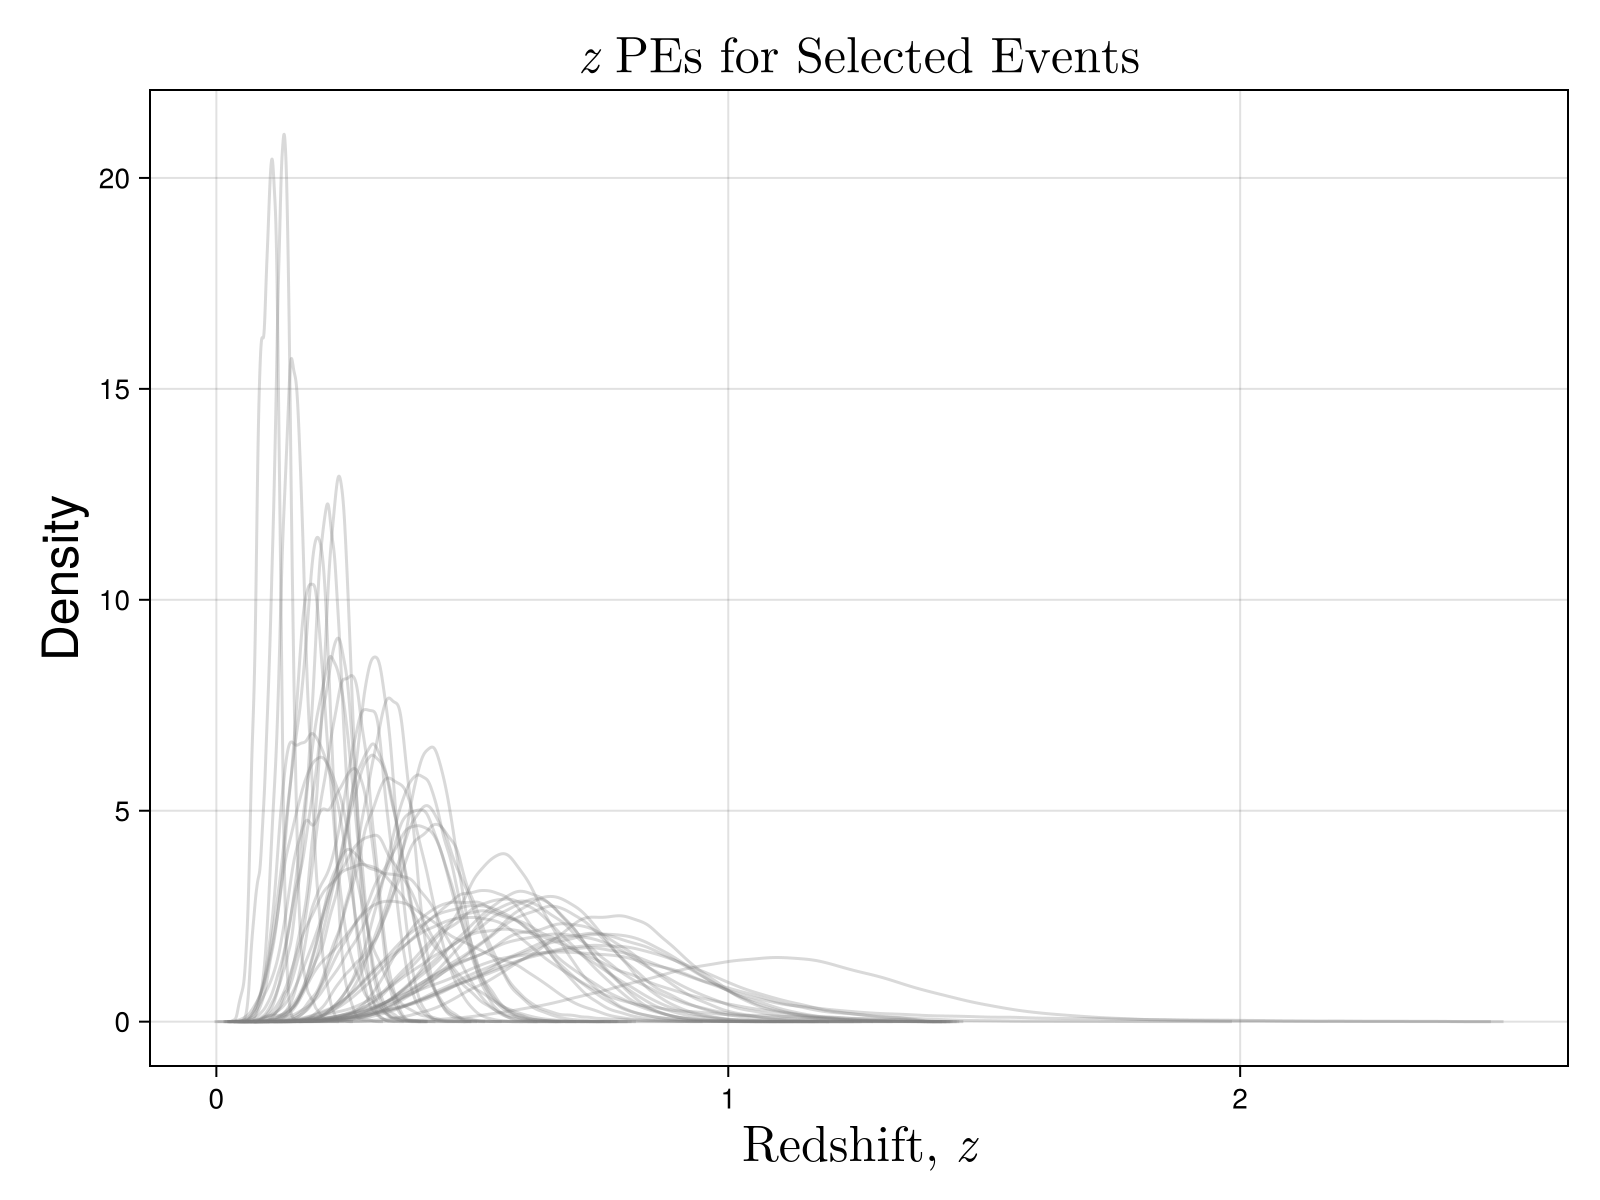

In [8]:
using KernelDensity
# Grouped data
pe_grouped = groups

# Set up figure and axis
f = Figure(size=(800, 600))
a = Axis(f[1, 1],
    xlabel = L"\mathrm{Redshift,~} z",
    ylabel = "Density",
    xlabelsize = 25,
    ylabelsize = 25,
    titlesize=25,
    title=L"z~\mathrm{PEs~for~Selected~Events}"
)

# Plot all PE redshift KDEs in grey
for evt in pe_grouped
    z = evt.redshift
    if length(z) < 2
        continue
    end
    kde_result = KernelDensity.kde(z)
    lines!(a, kde_result.x, kde_result.density, color = (:grey, 0.3))
end

# Save the figure
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/z_kde.pdf", f, px_per_unit = 3)

f

# Population Plots

In [9]:
trace_samples_0p5 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.5.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p5.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p5.posterior, :event)))"
trace = trace_samples_0p5

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.25, minimum Neff_sel = 1801.0, 4*Nobs = 204
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sdnNjb2RlLXJlbW90ZQ==.jl:4


InferenceData with groups:
  > posterior
  > sample_stats

## $m_1$ Marginal

In [10]:
function marginal_m1_plot_paper(trace; limits=(20.0, 50.0, 1.0, 100.0), yticks=[1, 10, 100], yminorticks=[2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90], kwargs...)
    f = Figure(size=(800, 600))
    a = Axis(f[1,1],
        xlabel = L"\mathrm{Primary~Mass},~m_1~(\mathrm{in~}M_\odot)",
        ylabel = L"m_1 \frac{\mathrm{d} N}{\mathrm{d} m_1 \mathrm{d} V \mathrm{d} t}~(z=0.5)~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
        xscale = log10, yscale = log10,
        xticks = [20, 25, 30, 35, 40, 45, 50], xtickformat = "{:.0f}",
        yticks = yticks, yminorticks = yminorticks, yminorticksvisible = true, ytickformat = "{:.0f}",
        xlabelsize = 20,
        ylabelsize = 20,
        titlesize=25,
        title=L"\mathrm{Marginal}~m_1~\mathrm{Population}",
        limits = limits
    )

    marginal_m1_plot_paper!(a, trace; kwargs...)

    axislegend(a, position = :rt, labelsize = 20, framevisible = true)  # top-right inside the plot

    f
end


function marginal_m1_plot_paper!(a, trace; z_plot=z_plot, ms=exp.(log(m_bh_min):0.01:log(m_bh_max)), qs=0.001:0.01:1, draws=100, rng=Random.default_rng(), color=Makie.wong_colors()[1], label="Median")
    p = trace.posterior
    dNdm1_matrix = zeros(length(ms), draws)

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, 1:length(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdm1 = map(ms) do m
            integrand = map(qs) do q
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
                end
            end
            m * p.R[chain=c, draw=d] * trapz(qs, integrand)
        end

        dNdm1_matrix[:, i] = dNdm1
    end

    # Compute quantiles
    q10 = mapslices(x -> quantile(x, 0.10), dNdm1_matrix; dims=2)[:]
    q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
    q90 = mapslices(x -> quantile(x, 0.90), dNdm1_matrix; dims=2)[:]

    # Plot
    band!(a, ms, q10, q90, color=(:blue, 0.2), label="90% interval")
    lines!(a, ms, q50, color=:blue, label=label)
end

marginal_m1_plot_paper! (generic function with 1 method)

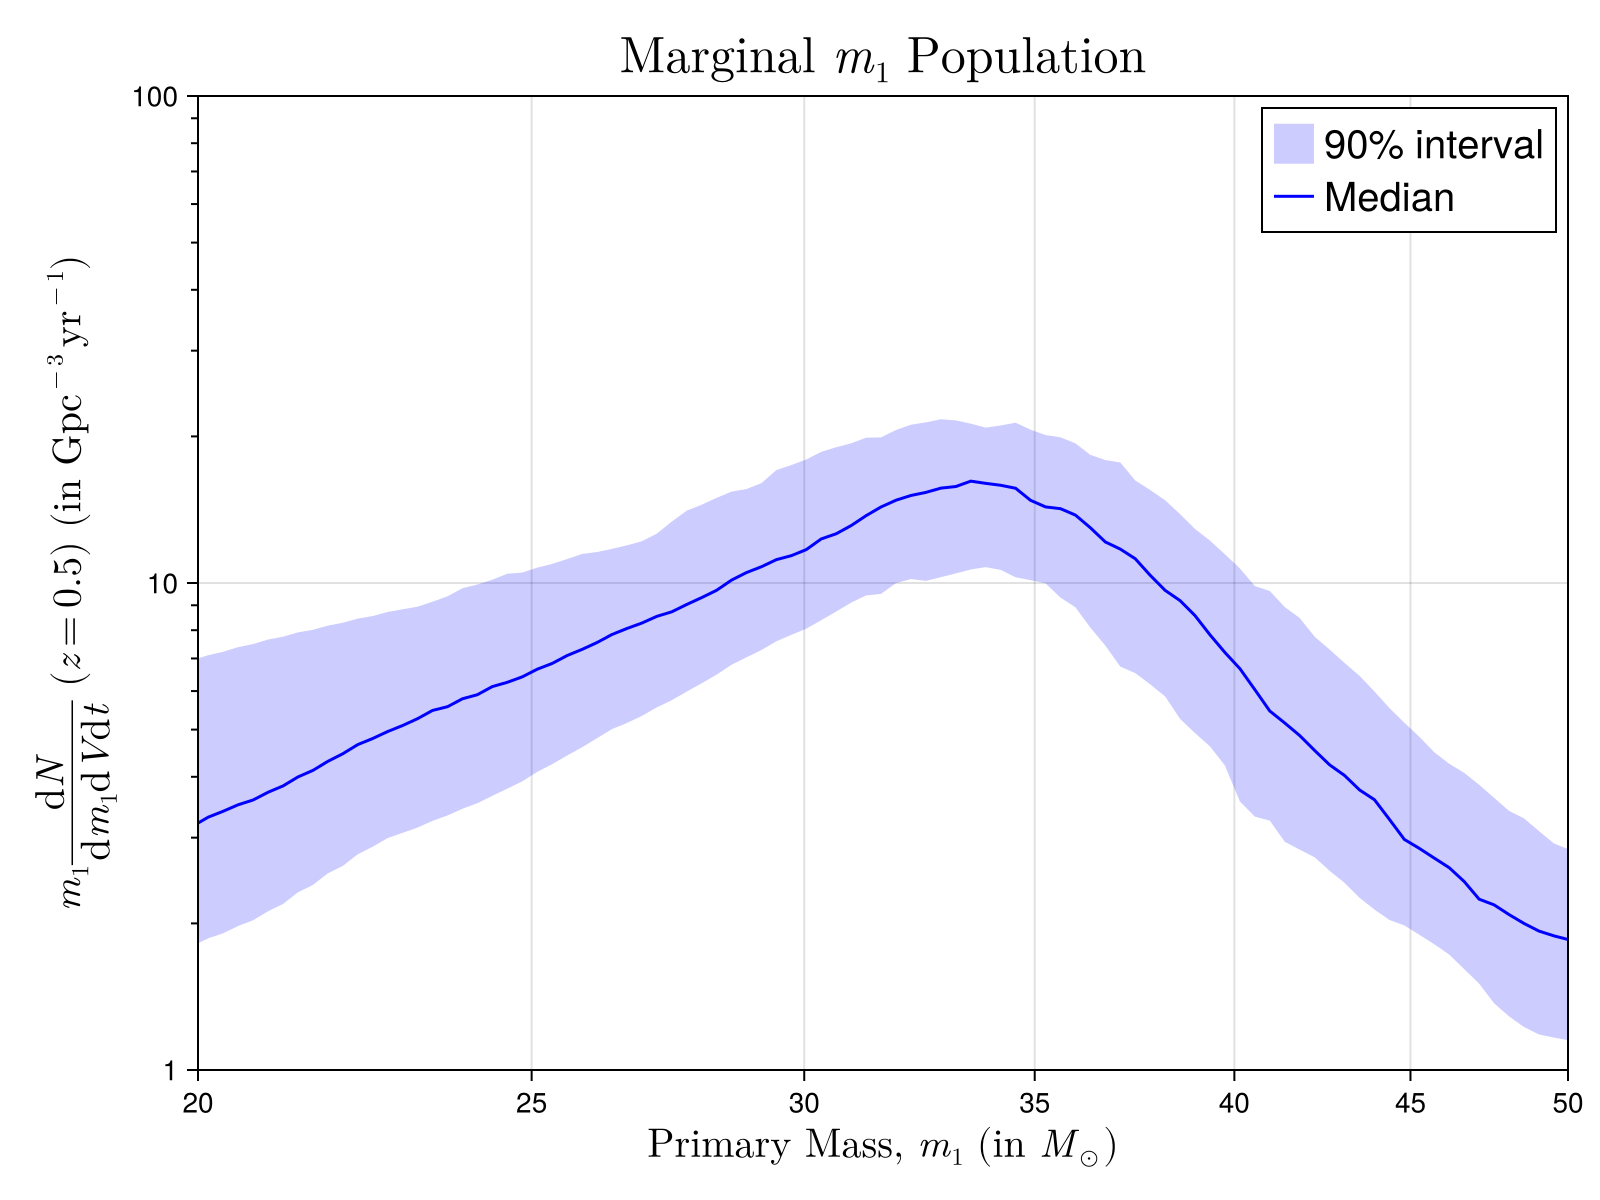

In [11]:
f = marginal_m1_plot_paper(trace)
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/m1_marginal_population.pdf", f, px_per_unit = 3)
f

## Structural Parameters

In [12]:
df = DataFrame([
    k => vec(trace.posterior[k])
    for k in [:alpha, :mtr, :mbhmax, :sigma]]...
)
labels = Dict(
    :alpha => L"\alpha", 
    :mtr => L"\frac{M_\mathrm{tr}}{\mathrm{M}_{\odot}}", 
    :mbhmax => L"\frac{M_\mathrm{BH,max}}{\mathrm{M}_{\odot}}", 
    :sigma => L"\frac{\sigma}{\mathrm{M}_{\odot}}"
)

f = pairplot(df; labels = labels)
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/m1_structure.pdf", f, px_per_unit = 3)
f

## $q-\chi_{\mathrm{eff}}$ Population

In [13]:
function q_chieff_corner_plot_paper(trace;
    m_plot=m_plot,
    z_plot=z_plot,
    limits = (-0.5, 0.5, 0.5, 1),
    chi_effs = collect(-1:0.01:1),
    qs = collect(0.001:0.01:1),
    levels = range(0.1, stop=1.0, length=10),
    draws = 100,
    rng = Random.default_rng(),
    colormap = :batlow
)

    # Setup grid
    f = Figure(resolution=(800, 800))

    grid = f[1,1] = GridLayout(tellwidth=false, tellheight=false)
    top_ax = Axis(grid[1, 2], xlabel="", ylabel="", xticksvisible=false, xgridvisible=true, ygridvisible=true)
    main_ax = Axis(grid[2, 2], xlabel=L"\mathrm{Effective~Spin},~\chi_\mathrm{eff}", ylabel=L"\mathrm{Mass~Ratio},~q", xlabelsize = 20, ylabelsize = 20, limits=limits, xgridvisible=true, ygridvisible=true)
    right_ax = Axis(grid[2, 3], xlabel=L"\mathrm{Mass~Ratio},~q", ylabel="", xlabelsize = 20, ylabelsize = 20, xticksvisible=true, xgridvisible=true, ygridvisible=true)

    colsize!(grid, 1, Relative(0.1))
    rowsize!(grid, 1, Relative(0.4))
    rowsize!(grid, 2, Relative(0.5)) 

    #############################
    # 1. 2D q-chi_eff contour plot
    #############################

    dchi_eff = chi_effs[2] - chi_effs[1]
    dq = qs[2] - qs[1]

    p = trace.posterior

    i = 0
    N = length(dims(p, :chain)) * length(dims(p, :draw))

    pqc_mean = [0.0 for ce in chi_effs, q in qs]

    @withprogress begin
        for c in span(dims(p, :chain))
            for d in span(dims(p, :draw))
                log_dN = log_dN_from_chain_sample(trace, d, c)

                pqc = [
                    if q * m_plot > m_bh_min
                        exp(log_dN(m_plot, q, ce, z_plot, 0.0))
                    else
                        zero(m_plot)
                    end
                    for ce in chi_effs, q in qs
                ]

                pqc ./= sum(pqc) * dchi_eff * dq

                pqc_mean .+= pqc

                i += 1
                @logprogress i/N
            end
        end
        pqc_mean ./= length(chi_effs) * length(qs)
    end

    vp = sort(vec(pqc_mean))
    vp_cum = cumsum(vp)
    vp_cum ./= vp_cum[end]

    vp_levels = [vp[argmin(abs.(vp_cum .- l))] for l in levels]

    blue_colormap = cgrad(:blues)

    contourf!(main_ax, chi_effs, qs, pqc_mean, levels=vp_levels, colormap=blue_colormap)

    #####################################
    # 2. Marginal over chi_eff (top plot) - updated with median + uncertainty band
    #####################################

    ms = exp.(range(log(m_bh_min), log(m_bh_max), length=100))
    dNdchi_samples = []

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdchi = map(chi_effs) do chi_eff
            m_integrand = map(ms) do m
                q_integrand = map(qs) do q
                    m2 = q*m
                    if m2 < m_bh_min
                        zero(m)
                    else
                        exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                    end
                end
                trapz(qs, q_integrand)
            end
            p.R[draw=d, chain=c] * trapz(ms, m_integrand)
        end

        push!(dNdchi_samples, dNdchi)
    end

    # Stack samples into a matrix
    dNdchi_matrix = reduce(hcat, dNdchi_samples)

    # Compute percentiles at each chi_eff
    dNdchi_median = mapslices(x -> median(x), dNdchi_matrix; dims=2)[:]
    dNdchi_p10    = mapslices(x -> quantile(x, 0.10), dNdchi_matrix; dims=2)[:]
    dNdchi_p90    = mapslices(x -> quantile(x, 0.90), dNdchi_matrix; dims=2)[:]

    band!(top_ax, chi_effs, dNdchi_p10, dNdchi_p90, color=(:blue, 0.2))  
    lines!(top_ax, chi_effs, dNdchi_median, color=:blue, linewidth=2)  

    top_ax.xlabel = L"\mathrm{Effective~Spin},~\chi_\mathrm{eff}"
    top_ax.ylabel = L"\frac{\mathrm{d}N}{\mathrm{d}\chi_\mathrm{eff}} \mid_{m_1=35\mathrm{M}_{\odot}, z=0.5}"
    top_ax.xlabelsize = 20
    top_ax.ylabelsize = 20
    top_ax.xticksvisible = true
    top_ax.yticksvisible = true

    
    ##################################
    # 3. Marginal over q (right plot)
    ##################################

    dNdq_samples = []

    @progress for _ in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdq = map(qs) do q
            integrand = map(ms) do m
                m2 = q*m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
                end
            end
            p.R[draw=d, chain=c] * trapz(ms, integrand)
        end

        push!(dNdq_samples, dNdq)
    end

    # Stack samples into a matrix
    dNdq_matrix = reduce(hcat, dNdq_samples)

    # Compute percentiles at each q
    dNdq_median = mapslices(x -> median(x), dNdq_matrix; dims=2)[:]
    dNdq_p10    = mapslices(x -> quantile(x, 0.10), dNdq_matrix; dims=2)[:]
    dNdq_p90    = mapslices(x -> quantile(x, 0.90), dNdq_matrix; dims=2)[:]

    b = band!(right_ax, qs, dNdq_p10, dNdq_p90, color=(:blue, 0.2))  
    l = lines!(right_ax, qs, dNdq_median, color=:blue, linewidth=2)  

    right_ax.xlabel = L"\mathrm{Mass~Ratio},~q"
    right_ax.ylabel = L"\frac{\mathrm{d}N}{\mathrm{d}q} \mid_{m_1=35\mathrm{M}_{\odot}, z=0.5}"
    right_ax.xlabelsize = 20
    right_ax.ylabelsize = 20
    right_ax.xticksvisible = true
    right_ax.yticksvisible = true

    hidespines!(right_ax, :l)
    hidespines!(top_ax, :b)

    # Create legend and add to the new top-right grid cell
    legend = Legend(f, [b, l], ["90% interval", "Median"]; labelsize = 20, tellwidth=false)
    grid[1, 3] = legend


    f
end


q_chieff_corner_plot_paper (generic function with 1 method)

In [14]:
f = q_chieff_corner_plot_paper(trace; m_plot=35.0, z_plot=0.5)
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/q_chieff_population.pdf", f, px_per_unit = 3)
f

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /mnt/home/sroy1/.julia/packages/Makie/6KcTF/src/scenes.jl:238


In [15]:
function chieff_cdf_plot_paper(
    trace;
    m_plot::Float64,
    z_plot::Float64,
    chi_effs = collect(-1.0:0.01:1.0),
    qs = collect(0.01:0.01:1.0),
    ms = exp.(range(log(m_bh_min), log(m_bh_max), length=100)),
    draws = 100,
    rng = Random.default_rng(),
    log_dN_from_chain_sample::Function
)
    dchi_eff = chi_effs[2] - chi_effs[1]

    p = trace.posterior
    dNdchi_samples = []

    for _ in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdchi = map(chi_effs) do chi_eff
            m_integrand = map(ms) do m
                q_integrand = map(qs) do q
                    m2 = q*m
                    if m2 < m_bh_min
                        0.0
                    else
                        exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                    end
                end
                trapz(qs, q_integrand)
            end
            p.R[draw=d, chain=c] * trapz(ms, m_integrand)
        end

        cdf = cumsum(dNdchi)
        cdf ./= cdf[end]  # normalize
        push!(dNdchi_samples, cdf)
    end

    cdf_matrix = reduce(hcat, dNdchi_samples)
    cdf_median = mapslices(x -> quantile(x, 0.5), cdf_matrix; dims=2)[:]
    cdf_p10    = mapslices(x -> quantile(x, 0.10), cdf_matrix; dims=2)[:]
    cdf_p90    = mapslices(x -> quantile(x, 0.90), cdf_matrix; dims=2)[:]

    fig = Figure(size=(800, 600))
    ax = Axis(fig[1, 1],
        xlabel=L"\mathrm{Effective~Spin},~\chi_\mathrm{eff}",
        ylabel=L"\mathrm{CDF}",
        xlabelsize=20, ylabelsize=20,
        xticksize=10, yticksize=10,
        titlesize=25, title=L"\mathrm{CDF~of~} \chi_\mathrm{eff} \mathrm{~at}~m_1=35\mathrm{M}_{\odot},~z=0.5,~\mathrm{Marginalized~over}~q",
        xgridvisible=true, ygridvisible=true
    )

    b = band!(ax, chi_effs, cdf_p10, cdf_p90, color=(:blue, 0.2))
    l = lines!(ax, chi_effs, cdf_median, color=:blue, linewidth=2)

    axislegend(ax, [b, l], ["90% interval", "Median"],
        position = :lt,  # top left corner
        labelsize = 16,
        framevisible = true)

    fig
end


chieff_cdf_plot_paper (generic function with 1 method)

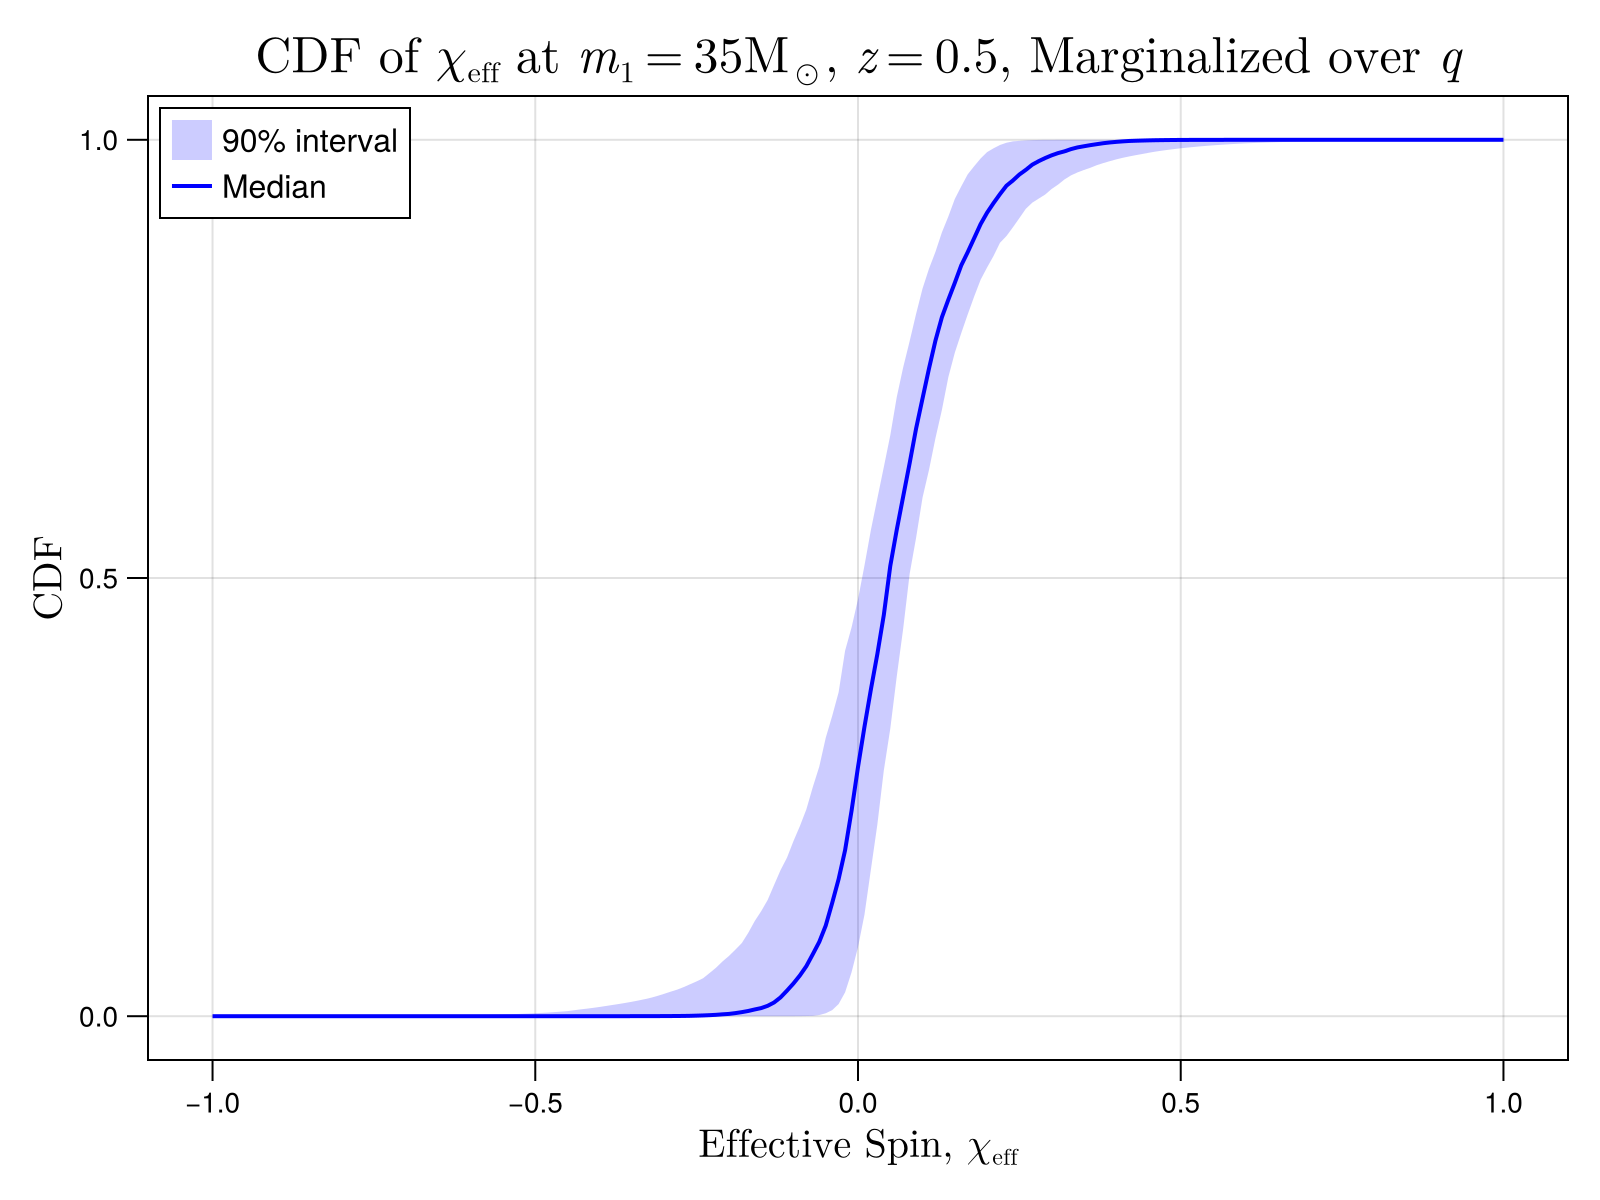

In [16]:
f = chieff_cdf_plot_paper(
    trace;
    m_plot=35.0,
    z_plot=0.5,
    draws=200,
    log_dN_from_chain_sample=log_dN_from_chain_sample
)
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/cdf_chieff.pdf", f, px_per_unit = 3)
f

## How $\chi_{\mathrm{eff}}$ Depends on $q$?

In [17]:
function plot_mean_chi_eff_vs_q_paper(trace)
    mul_samples = vec(trace.posterior.mul)
    alpha_samples = vec(trace.posterior.alpha_chi_eff)

    q_vals = range(0.5, 1.0; length=200)

    medians = Float64[]
    lowers = Float64[]
    uppers = Float64[]

    for q in q_vals
        chi_eff_samples = mul_samples .+ alpha_samples .* q
        push!(medians, StatsBase.median(chi_eff_samples))
        ci = StatsBase.quantile(chi_eff_samples, [0.05, 0.95])
        push!(lowers, ci[1])
        push!(uppers, ci[2])
    end

    fig = Figure(size=(800, 600))
    ax = Axis(fig[1, 1], 
        xlabel=L"\mathrm{Mass~Ratio},~q", 
        ylabel=L"\mathrm{Mean~of~Effective~Spin},~\langle \chi_{\mathrm{eff}} \rangle", 
        xlabelsize=20,
        ylabelsize=20,
        xticklabelsize=16,
        yticklabelsize=16,
        titlesize=25,
        title=L"\mathrm{Mean~of}~\chi_{\mathrm{eff}}~\mathrm{with}~q"
    )

    band_plot = band!(ax, q_vals, lowers, uppers, color=(:blue, 0.2))
    line_plot = lines!(ax, q_vals, medians, color=:blue, linewidth=2)

    axislegend(ax, [band_plot, line_plot], ["90% interval", "Median"];
               position = :rt,  # top-left; you can use :rt, :lb, :rb, etc.
               labelsize = 20,
               framevisible = true)

    return fig
end


plot_mean_chi_eff_vs_q_paper (generic function with 1 method)

In [18]:
f = plot_mean_chi_eff_vs_q_paper(trace)
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/Mean_chieff_wq.pdf", f, px_per_unit = 3)
f

In [19]:
function plot_std_chi_eff_vs_q_paper(trace)
    sigmal_samples = vec(trace.posterior.sigmal)
    beta_samples = vec(trace.posterior.beta_chi_eff)

    q_vals = range(0.5, 1.0; length=200)

    medians = Float64[]
    lowers = Float64[]
    uppers = Float64[]

    for q in q_vals
        chi_eff_samples = sigmal_samples .+ beta_samples .* q
        push!(medians, StatsBase.median(chi_eff_samples))
        ci = StatsBase.quantile(chi_eff_samples, [0.05, 0.95])
        push!(lowers, ci[1])
        push!(uppers, ci[2])
    end

    fig = Figure(size=(800, 600))
    ax = Axis(fig[1, 1], 
        xlabel=L"\mathrm{Mass~Ratio},~q", 
        ylabel=L"\mathrm{Standard~Deviation~of~Effective~Spin},~\mathrm{std}(\chi_{\mathrm{eff}})", 
        xlabelsize = 20,
        ylabelsize = 20,
        xticklabelsize=16,
        yticklabelsize=16,
        titlesize = 25,
        title=L"\mathrm{Standard~Deviation~of}~\chi_{\mathrm{eff}}~\mathrm{with}~q"
    )

    band_plot = band!(ax, q_vals, lowers, uppers, color=(:blue, 0.2))
    line_plot = lines!(ax, q_vals, medians, color=:blue, linewidth=2)

    axislegend(ax, [band_plot, line_plot], ["90% interval", "Median"];
               position = :rt,  # top-left
               labelsize = 20,
               framevisible = true)

    return fig
end


plot_std_chi_eff_vs_q_paper (generic function with 1 method)

In [20]:
f = plot_std_chi_eff_vs_q_paper(trace)
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/Std_chieff_wq.pdf", f, px_per_unit = 3)
f

## $z$ Marginal

In [21]:
function marginal_z_plot_paper(trace;
    ms = exp.(log(m_bh_min):0.01:log(m_bh_max)),
    qs = 0.001:0.01:1,
    zs = expm1.(range(log(1), stop=log(1 + 2), length=128)),
    draws = 100,
    rng = Random.default_rng(),
    limits = (0, 2, 1, 1000),
    yticks = [1, 10, 100, 1000],
    yminorticks = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900],
    plot_md_line = true,
    color = Makie.wong_colors()[1]
)
    f = Figure(size=(800, 600))
    a = Axis(f[1, 1],
        xlabel = L"\mathrm{Redshift},~z",
        ylabel = L"\frac{\mathrm{d} N}{\mathrm{d} V \mathrm{d} t}~(\mathrm{in~}\mathrm{Gpc}^{-3}\mathrm{yr}^{-1})",
        yscale = log10,
        xlabelsize = 20,
        ylabelsize = 20,
        xticklabelsize = 16,
        yticklabelsize = 16,
        titlesize = 25,
        title = L"\mathrm{Marginalized}~z~\mathrm{Population}",
        ytickformat = "{:.0f}",
        yticks = yticks,
        yminorticks = yminorticks,
        yminorticksvisible = true,
        xminorticksvisible = true,
        limits = limits
    )

    p = trace.posterior
    dNs = zeros(length(zs), draws)

    @progress for j in 1:draws
        c = rand(rng, span(dims(p, :chain)))
        d = rand(rng, span(dims(p, :draw)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        z1 = zs[1]
        dNdms = map(ms) do m
            integrand = map(qs) do q
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, 0.0, z1, 0.0; ignore_chi_eff=true))
                end
            end
            trapz(qs, integrand)
        end

        norm = trace.posterior.R[draw=d, chain=c] *
               trapz(ms, dNdms) /
               exp(log_dN(m_plot, q_plot, 0.0, z1, 0.0; ignore_chi_eff=true))

        dNdz = map(zs) do z
            norm * exp(log_dN(m_plot, q_plot, 0.0, z, 0.0; ignore_chi_eff=true))
        end

        dNs[:, j] = dNdz
    end

    medians = mapslices(median, dNs; dims=2)[:]
    lowers = mapslices(x -> quantile(x, 0.05), dNs; dims=2)[:]
    uppers = mapslices(x -> quantile(x, 0.95), dNs; dims=2)[:]

    band_plot = band!(a, zs, lowers, uppers, color=(:blue, 0.2))
    median_plot = lines!(a, zs, medians, color=:blue, linewidth=2)

    sfr_plot = nothing
    if plot_md_line
        vs = vec(var(log.(dNs), dims=2))
        imin = argmin(vs)
        norm = median(dNs[imin, :])

        mds = @. (1 + zs)^2.7 / (1 + ((1 + zs)/(1 + 1.9))^5.6)
        mds = mds .* norm ./ mds[imin]

        sfr_plot = lines!(a, zs, mds, color=:black, linestyle=:dash, linewidth=2)
    end

    plots = [band_plot, median_plot]
    labels = ["90% interval", "Median"]
    if plot_md_line && sfr_plot !== nothing
        push!(plots, sfr_plot)
        push!(labels, "Star Formation Rate")
    end

    axislegend(a, plots, labels; position=:lt, labelsize=20, framevisible=true)

    return f
end


marginal_z_plot_paper (generic function with 1 method)

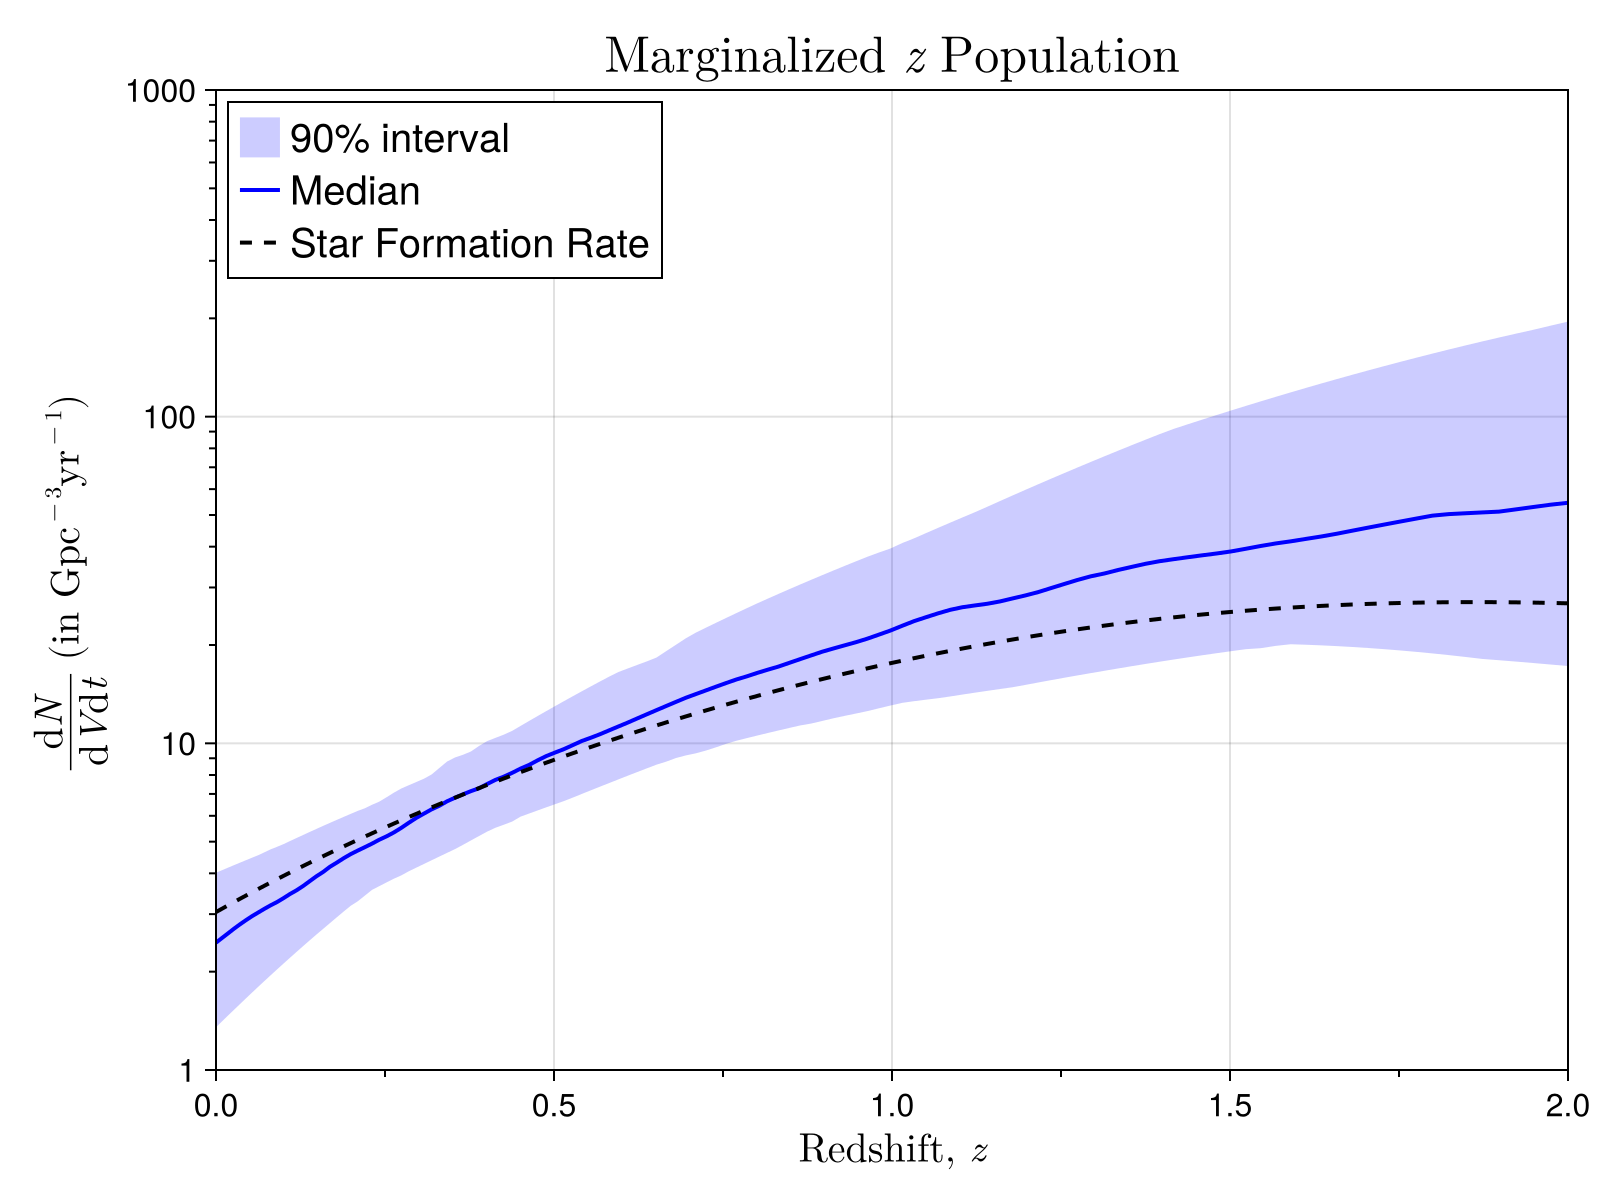

In [22]:
f = marginal_z_plot_paper(trace)
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/z_marginal_population.pdf", f, px_per_unit = 3)
f

# Astrophysical Interpretation

## Remnant Mass Function

In [23]:
function remnant_mass_dist_plot_paper(trace;
    mgrid = exp.(range(log(20.0), log(50.0), length=300)),
    draws = 100,
    rng = Random.default_rng(),
    yticks = [0.01, 0.1, 1.0],
    yminorticks = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                   0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    color = :blue
)
    p = trace.posterior
    dNdm = zeros(length(mgrid), draws)

    @progress for j in 1:draws
        try
            d = rand(rng, span(dims(p, :draw)))
            c = rand(rng, span(dims(p, :chain)))
            log_dN = log_dNdm_from_chain_sample(trace, d, c)

            raw = map(mgrid) do m
                val = try
                    exp(log_dN(m))
                catch
                    NaN
                end
                isnan(val) ? 0.0 : val
            end

            norm = trapz(mgrid, raw)
            if norm > 0
                dNdm[:, j] .= mgrid .* raw ./ norm
            else
                @warn "Normalization is zero for sample $j"
                dNdm[:, j] .= 0.0
            end
        catch e
            @warn "Sample $j failed: $e"
            dNdm[:, j] .= 0.0
        end
    end

    medians = mapslices(median, dNdm; dims=2)[:]
    lowers = mapslices(x -> quantile(x, 0.05), dNdm; dims=2)[:]
    uppers = mapslices(x -> quantile(x, 0.95), dNdm; dims=2)[:]

    ymin = max(0.01, minimum(lowers[lowers .> 0]))
    ymax = 10.0 ^ ceil(log10(maximum(uppers)))
    limits = (minimum(mgrid), maximum(mgrid), ymin, ymax)

    f = Figure(size=(800, 600))
    a = Axis(f[1, 1],
        xlabel = L"\mathrm{Remnant~Mass}~(\mathrm{in~}M_\odot)",
        ylabel = L"m \, f(m)",
        xscale = log10,
        yscale = log10,
        xlabelsize = 20,
        ylabelsize = 20,
        xticklabelsize = 16,
        yticklabelsize = 16,
        titlesize = 25,
        title = L"\mathrm{Remnant~Mass~Distribution}",
        yticks = yticks,
        yminorticks = yminorticks,
        yminorticksvisible = true,
        xminorticksvisible = true,
        xticks = [20, 25, 30, 35, 40, 45, 50],
        xtickformat = "{:.0f}",
        ytickformat = "{:.2f}",
        limits = limits
    )

    band_plot = band!(a, mgrid, lowers, uppers, color=(color, 0.2))
    median_plot = lines!(a, mgrid, medians, color=color, linewidth=2)

    axislegend(a, [band_plot, median_plot], ["90% interval", "Median"];
               position = :rt, labelsize = 20, framevisible = true)

    return f
end


remnant_mass_dist_plot_paper (generic function with 1 method)

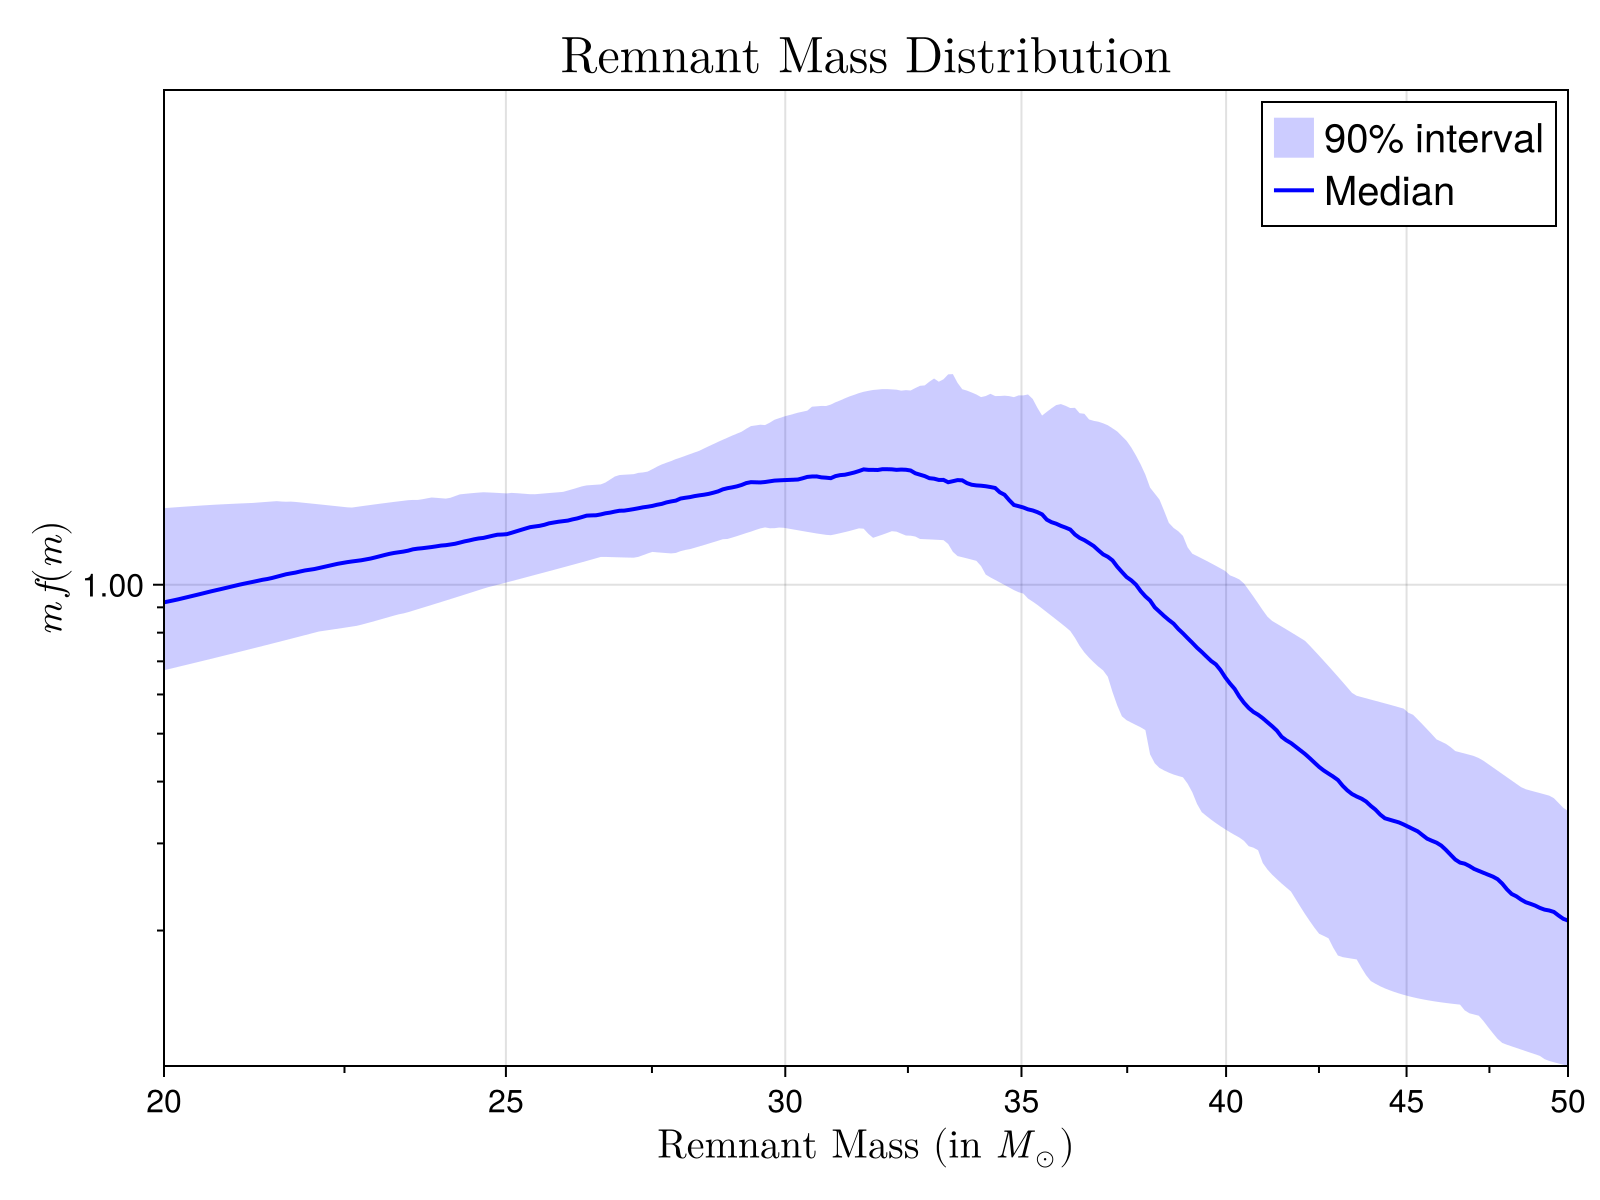

In [24]:
f = remnant_mass_dist_plot_paper(trace)
save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/remnant_mass_dist.pdf", f, px_per_unit = 3)
f

## 2G-2G Merger
## $\mu$ and $\sigma$ of $\chi_{\mathrm{eff}}$ at $q=1$

In [25]:
# 2g2g mu-sigma versus our fit
limit_2g2g = 0.7
width_2g2g = 2 * limit_2g2g
std_2g2g = width_2g2g / sqrt(12)

q_2g2g = 1.0  # For 2g2g mergers

f = Figure(size=(600, 600))

ax = Axis(f[1, 1],
    xlabel = L"\mathrm{Mean~of~Effective~Spin~at}~q=1,~\mu \mid_{q=%$(q_2g2g)}",
    ylabel = L"\mathrm{Standard~Deviation~of~Effective~Spin~at}~q=1,~\sigma \mid_{q=%$(q_2g2g)}",
    xlabelsize = 20,
    ylabelsize = 20,
    xticklabelsize = 16,
    yticklabelsize = 16,
    titlesize = 25,
    title = L"35\mathrm{M}_{\odot}~\mathrm{as~a~2G-2G~Merger~Peak?}")

xvals = chieff_interp.(q_2g2g, vec(trace.posterior.mul), vec(trace.posterior.muh))
yvals = chieff_interp.(q_2g2g, vec(trace.posterior.sigmal), vec(trace.posterior.sigmah))

kdecontour!(ax, xvals, yvals, levels = 0.1:0.1:0.9, color = :blue)

scatter!(ax, [0.0], [std_2g2g], color = :black, markersize = 10)

legend_line = lines!([NaN], [NaN], color = :blue)
legend_dot = scatter!([NaN], [NaN], color = :black, markersize = 10)

axislegend(ax, [legend_line, legend_dot],
    ["This Paper", "2G-2G Merger"],
    position = :rt,
    labelsize = 20,
    framevisible = true
)

text!(ax, "90%", position = (0.04, 0.11), align = (:left, :bottom), fontsize = 18, color = :blue)

save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/2G2G.pdf", f, px_per_unit = 3)
f

## 2G-1G Merger
## $\mu$ and $\sigma$ of $\chi_{\mathrm{eff}}$ at $q=0.5$

In [26]:
# 2G-1G mu-sigma versus our fit
limit_2g1g = 0.7 / 1.5
width_2g1g = 2 * limit_2g1g
std_2g1g = width_2g1g / sqrt(12)

q_2g1g = 0.5  # For 2G-1G mergers

f = Figure(size = (600, 600))

ax = Axis(f[1, 1],
    xlabel = L"\mathrm{Mean~of~Effective~Spin~at}~q=0.5,~\mu \mid_{q=%$(q_2g1g)}",
    ylabel = L"\mathrm{Standard~Deviation~of~Effective~Spin~at}~q=0.5,~\sigma \mid_{q=%$(q_2g1g)}",
    xlabelsize = 20,
    ylabelsize = 20,
    xticklabelsize = 16,
    yticklabelsize = 16,
    titlesize = 25,
    title = L"35\mathrm{M}_{\odot}~\mathrm{as~a~2G\!-\!1G~Merger~Peak?}"
)

xvals = chieff_interp.(q_2g1g, vec(trace.posterior.mul), vec(trace.posterior.muh))
yvals = chieff_interp.(q_2g1g, vec(trace.posterior.sigmal), vec(trace.posterior.sigmah))

kdecontour!(ax, xvals, yvals, levels = 0.1:0.1:0.9, color = :blue)

scatter!(ax, [0.0], [std_2g1g], color = :black, markersize = 10)

legend_line = lines!([NaN], [NaN], color = :blue)
legend_dot = scatter!([NaN], [NaN], color = :black, markersize = 10)

axislegend(ax, [legend_line, legend_dot],
    ["This Paper", "2G–1G Merger"],
    position = :rt,
    labelsize = 20,
    framevisible = true
)

text!(ax, "90%", position = (0.08, 0.25), align = (:left, :bottom), fontsize = 18, color = :blue)

save("/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/2G1G.pdf", f, px_per_unit = 3)
f
